# First Kaggle Script: Tuning Random Forest Parameters
### *Daniel Haden*
*August 7th, 2016*

[1 Introduction](#Introduction)
* [1.1 Loading and Checking Data](#Loading)
* [1.2 Looking for NaNs](#Looking)

[2 Handling Missing Values](#Handling)
* [2.1 Removing variables with too little coverage](#Removing)
* [2.2 Filling in NaN's for variables with high coverage](#Filling)
* [2.3 Imputing Missing Age Values](#Imputing)

[3 Formatting Data for Sklearn and Examining RF Algorithm Parameters](#Formatting)
* [3.1 Converting categorical variable labels](#Converting)
* [3.2 Tuning RF parameters (somewhat methodically)](#Tuning)

[4 Training Final Classifier](#Training)

[5 Conclusion](#Conclusion)

<a name="Introduction"></a>
## 1 Introduction

This is my first attempt at a Kaggle dataset - I was inspired by some very good notebooks by [Megan Risdal](https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/notebook) and [Sadat Nazrul](https://www.kaggle.com/creepykoala/titanic/study-of-tree-and-forest-algorithms/comments) and thought I'd give it a try myself.  The data exploration portion is pretty standard - I tried to focus on how to tune parameters for the RF classifier.  My goal was  to find a semi-automated way of tuning algorithm parameters. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from time import time
import matplotlib.pyplot as plt
from operator import itemgetter

# Stop deprecation warnings from being printed
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<a name="Loading"></a>
### 1.1 Loading and Checking Data

In [2]:
# Load training and test data into pandas dataframes
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

# merge training and test sets into one dataframe
full = pd.concat([train, test])

In [3]:
# Get size of dataframes
for dataframe in [train, test, full]:
    print(dataframe.shape)

(891, 12)
(418, 11)
(1309, 12)


In [4]:
full.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599


So the dataset has been split approximately 70/30% for training/testing.  Here's a description of some of the more cryptic variable names:

 **Variable** | **Description** 
-------- | -----------
 Embarked | Port of embarkation (S = Southhampton, C = Chersbourg, Q = Queenstown) 
 Parch | Number of parents/children of passenger on board 
 Pclass | Passenger's class (1st, 2nd, or 3rd) 
 SibSp | Number of siblings or spouses on board 

<a name="Looking"></a>
### 1.2 Looking for NaN's

Next, let's look at how complete the dataset is.

In [5]:
#return a formatted percentage from a fraction
def percentage(numerator, denomenator):
    
    if type(numerator) == pd.core.series.Series:
        return (numerator/denomenator*100).map('{:.1f}%'.format)
    
    elif type(numerator) == int or type(numerator) == float:
        return '{:.1f}%'.format(float(numerator)/float(denomenator)*100) 
    
    else:
        print("check type")

In [6]:
#Get percentage by variable of values which are not NaN
percentage(full.count()-1, full.shape[0]-1)

Age             79.9%
Cabin           22.5%
Embarked        99.8%
Fare            99.9%
Name           100.0%
Parch          100.0%
PassengerId    100.0%
Pclass         100.0%
Sex            100.0%
SibSp          100.0%
Survived        68.0%
Ticket         100.0%
dtype: object

So there are four variables with NaN values: *age, cabin, embarked*, and *fare*.

<a name="Handling"></a>
## 2 Handling Missing Values 
When using a random forest classifier(RCF), missing values [are usually handled](http://nerds.airbnb.com/overcoming-missing-values-in-a-rfc/) by either dropping a row or column or by filling in missing values using the average.  There are more sophisticated imputation techniques like k-nearest neighbors but I'm only going to use simple techniques here.

<a name="Removing"></a>
### 2.1 Removing variables with too little coverage
Cabin number has by far the least coverage (less than 1/4 of passengers have a recorded cabin number), so I'll look at the data in this column first.

In [7]:
# Get cabin #'s in list
cabin_numbers = full[full.Cabin.notnull()]['Cabin'].tolist()
cabin_numbers[:10]

['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78', 'D33']

The letter in each cabin number refers to the deck the cabin was on.  From [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-deckplans/), *Titanic's* decks were labeled A to F from top to bottom.

In [8]:
# Number of passengers w/ cabin numbers by class
full[full.Cabin.notnull()].groupby('Pclass')['Pclass'].count()

Pclass
1    256
2     23
3     16
Name: Pclass, dtype: int64

The vast majority of recorded cabin numbers came from first class passengers.  And by percentage,

In [9]:
# Percentage of passengers w/ cabin numbers by class
percentage(full[full.Cabin.notnull()].groupby('Pclass')['Pclass'].count(),
           full.groupby('Pclass')['Pclass'].count()
          )

Pclass
1    79.3%
2     8.3%
3     2.3%
Name: Pclass, dtype: object

So most first class passengers had their cabin numbers recorded in the dataset, yet only a small fraction of 2nd and 3rd class passengers had theirs recorded.  If we consider survival also,

In [10]:
# Number of passengers w/ cabin numbers by class AND survival
train[train.Cabin.notnull()].groupby(['Pclass', 'Survived'])['Cabin'].count()

Pclass  Survived
1       0            59
        1           117
2       0             3
        1            13
3       0             6
        1             6
Name: Cabin, dtype: int64

So simply having a cabin number recorded gives you a survival advantage.  There are obviously non-random reasons for the distribution of cabin numbers, like [survivorship bias](https://en.wikipedia.org/wiki/Survivorship_bias).  We could fill in NaN cabin values with an arbitrary value, say '0', and predict that anyone with a cabin number `!= 0` would survive.  The problem with this is that missingness of this variable is non-random, and this prediction would be based on a peculariaty of the dataset and not on an underlying relationship between survival and cabin number.

In [11]:
# How classes were distributed by deck (decks were labeled A-G from top to bottom of ship)
full['Deck'] = full.Cabin.str.extract("([a-zA-Z])", expand=False)
full[full.Cabin.notnull()].groupby(['Deck', 'Pclass'])['Deck'].count()

Deck  Pclass
A     1         22
B     1         65
C     1         94
D     1         40
      2          6
E     1         34
      2          4
      3          3
F     2         13
      3          8
G     3          5
T     1          1
Name: Deck, dtype: int64

As a side note, it's interesting that deck E contained 1st, 2nd, and 3rd class cabins.  There's definitely more that can be gleaned from these data, but that's as far as I want to go into it here.  I'll remove this column from the set,

In [12]:
# Remove 'Cabin' column from dataset
full = full.drop(['Cabin', 'Deck'], 1);

<a name="Filling"></a>
### 2.2 Filling in NaN's for variables with high coverage
Both embarked and fare variables have >99% coverage.  This is such a low number of NaN's that we can look at each entry individually.  I'll look at embarked first.

In [13]:
# find entries where port of embarkation is null
full[full.Embarked.isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


I wonder if the ticket number corresponds to port of embarkation.  Since the ticket number is a 6 digit number, perhaps the tickets were issued sequentially by port. (i.e. lower ticket numbers correspond to passengers who embarked at Southhampton (first port) while higher ticket numbers correspond to Queenstown passengers).

In [14]:
# Extract first three characters from ticket number and look for partterns from port of embarkation
full['ticket_header'] = full.Ticket.str.extract("([a-zA-Z0-9]{3})", expand=False)
full.groupby(['ticket_header', 'Embarked'])['Ticket'].count().head(12)

ticket_header  Embarked
104            S            1
110            C            2
               S           11
111            C            4
               S            5
112            C            5
               S            9
113            C           10
               S           54
116            S            3
117            C           10
               S            8
Name: Ticket, dtype: int64

Unfortunately, it does not look like tickets were issued in this manner.  The ticket header `113` that we are interested in was assigned to Southampton *and* Chersbourg passengers, though there are large majority of Southhampton passengers for this ticket header.  While I was working on the problem, I stumbled on [this](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html), which gives the port of embarkation(PoE) as Southhampton for both these passengers.

How could this value be imputed if there weren't this additional source?  I think using the mode to impute this categorical variable would be the best option.  In this example, using the mode for ticket_prefix would land us the right value of 'S'.  Of course, other subgroup averages are possible.  For example, we could use the mode for first class female passengers,

In [15]:
full.groupby(['Sex', 'Pclass', 'Embarked'])['Embarked'].count().head(3)

Sex     Pclass  Embarked
female  1       C           71
                Q            2
                S           69
Name: Embarked, dtype: int64

However, this mode would assign the NaN values the wrong value of 'C'.  It's not clear which subgroup mode to use but I would say that groups like ticket number and fare are better, in this case, for imputing PoE since these variables are related directly, whereas *passenger characteristics* like class and gender are only circumstantially related.

In [16]:
full.set_value(61, 'Embarked', 'S');
full.set_value(829, 'Embarked', 'S');

Let's examine fare NaN's now,

In [17]:
full[full.Fare.isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,ticket_header
152,60.5,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,370


In [18]:
# look at fare statistics for passengers traveling alone or with 1 spouse/sibling 
# and with ticket  beginning with '370'
full[full.ticket_header == '370'].groupby(['Parch', 'SibSp'])['Fare'].describe().head(8)

/opt/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Parch  SibSp       
0      0      count    9.00
              mean     7.75
              std      0.00
              min      7.75
              25%       NaN
              50%       NaN
              75%       NaN
              max      7.75
Name: Fare, dtype: float64

So all tickets starting with '370' were priced at 7.75 for passenger's traveling alone.  I will set the passengers fare as 7.75,

In [19]:
full.set_value(152, 'Fare', 7.75);

In [20]:
# remove 'ticket_header' and 'ticket' columns from data frame
full = full.drop(['ticket_header', 'Ticket'], 1);

<a name="Imputing"></a>
### 2.3 Imputing Missing Age Values
Before we impute age values, I want to see if any information about a passenger's age can be gleaned from their title.

In [21]:
# Extract title from name column using RE and put in new column labeled 'Title'
full['Title']= full.Name.str.extract("(.*, )([^\.]+)", expand=False)[1]
full.groupby('Title')['Name'].count()

Title
Capt              1
Col               4
Don               1
Dona              1
Dr                8
Jonkheer          1
Lady              1
Major             2
Master           61
Miss            260
Mlle              2
Mme               1
Mr              757
Mrs             197
Ms                2
Rev               8
Sir               1
the Countess      1
Name: Name, dtype: int64

In [22]:
# Convert French titles like Mlle and Mme to English equivalent and convert all other titles to 'Rare'
full.loc[full.Title == 'Mlle', 'Title'] = 'Miss'
full.loc[full.Title == 'Mme', 'Title'] = 'Mrs'
full.loc[~full.Title.isin(['Master', 'Mr', 'Mrs', 'Miss']), 'Title'] = 'Rare'

In [23]:
full.groupby('Title')['Name'].count()

Title
Master     61
Miss      262
Mr        757
Mrs       198
Rare       31
Name: Name, dtype: int64

In [24]:
# Look at survivorship numbers by title
full[full.Survived.notnull()].groupby(['Title', 'Survived'])['Name'].count()

Title   Survived
Master  0.0          17
        1.0          23
Miss    0.0          55
        1.0         129
Mr      0.0         436
        1.0          81
Mrs     0.0          26
        1.0         100
Rare    0.0          15
        1.0           9
Name: Name, dtype: int64

In [25]:
# Look at median age by title
full.groupby(['Title'])['Age'].median()

Title
Master     4.0
Miss      22.0
Mr        29.0
Mrs       35.0
Rare      47.0
Name: Age, dtype: float64

In [26]:
# Look at standard deviation of age by title
full.groupby(['Title'])['Age'].std()

Title
Master     4.161554
Miss      12.192794
Mr        12.422089
Mrs       12.902087
Rare      11.362587
Name: Age, dtype: float64

Clearly titles like 'Master' applied to small children but all titles, have a distinct and quite different median.  We can divide these subgroups further,

In [27]:
# Look at median age by title and class
full.groupby(['Title', 'Pclass'])['Age'].median()

Title   Pclass
Master  1          6.0
        2          2.0
        3          6.0
Miss    1         30.0
        2         20.0
        3         18.0
Mr      1         41.5
        2         30.0
        3         26.0
Mrs     1         45.0
        2         30.5
        3         31.0
Rare    1         48.5
        2         41.0
        3          NaN
Name: Age, dtype: float64

So 3rd class passengers skewed younger than 2nd class passengers, who skewed younger than 1st class passengers.  This pattern repeats for each title (except 'Master').

Missing age values will be filled in with the mode of the passengers title and class subgroup.

In [28]:
full_ver2 = full.copy()

In [29]:
# create dataframe with median ages by class and title
age_summary = full.groupby(['Title', 'Pclass'])['Age'].median().to_frame()
age_summary = age_summary.reset_index()

for index in full_ver2[full_ver2.Age.isnull()].index:
    median = age_summary[(age_summary.Title == full_ver2.iloc[index]['Title'])& \
                         (age_summary.Pclass == full_ver2.iloc[index]['Pclass'])]['Age'].values[0]
    full_ver2.set_value(index, 'Age', median)

<a name="Formatting"></a>
## Formatting Data for Sklearn and Examining RF Algorithm Parameters

<a name="Converting"></a>
### 3.1 Converting categorical variable labels
The `RandomForestClassifier` in `sklearn` does not accept string labels for categorical variables.  The `LabelEncoder` module can be used to convert categorical names into numerical names.  Below, I use `LabelEncoder` and also split the training set further into a 70/30% training/test for assessing algorithm parameters using `GridSearchCV`.

In [30]:
# format and split dataset for RF fitting.
def train_test_split(dataframe):
    try:
        # change gender labels to '0' or '1'
        dataframe["Sex"] = dataframe["Sex"].apply(lambda sex: 0 if sex == "male" else 1)
        
        convert = LabelEncoder()
        
        # change embarkation to numerical labels
        embarked = convert.fit_transform(dataframe.Embarked.tolist())
        dataframe['Embarked'] = embarked
        
        # change title to numerical labels
        title = convert.fit_transform(dataframe.Title.tolist())
        dataframe['Title'] = title    
        
    except:
        "dataframe is not correctly formatted"
    
    # split into training and test sets and move survival labels to list
    return dataframe[0:891].drop('Survived', 1), \
           dataframe[891:].drop('Survived', 1), \
           dataframe[0:891]['Survived'].tolist()

In [31]:
train_ver2, test_ver2, labels = train_test_split(full_ver2)

I'm setting the random state variable to prevent random fluctuations appearing significant.  I won't use it in the final classifier.

In [32]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_ver2, labels, test_size=0.3, random_state=42);

<a name="Tuning"></a>
### 3.2 Tuning RF parameters (somewhat methodically)
There are many more RF parameter configurations than can be practically be computed.  The plot below illustrates this,

In [33]:
# calculate the time to run a GridSearchCV for multiple numbers of parameter permutations.  
grid_times = {}
clf = RandomForestClassifier(random_state = 84)

features = X_train.columns.drop(['Name', 'PassengerId'], 1)

# I commented this out after running once locally since this block of code takes a long time to run
'''
for number in np.arange(2, 600, 50):
    
    param = np.arange(1,number,10)
    param_grid = {"n_estimators": param,
                  "criterion": ["gini", "entropy"]}
    
    grid_search = GridSearchCV(clf, param_grid = param_grid)
    
    t0 = time()
    grid_search.fit(X_train[features], y_train)
    compute_time = time() - t0
    grid_times[len(grid_search.grid_scores_)] = time() - t0
    
grid_times = pd.DataFrame.from_dict(grid_times, orient = 'index')
'''

# hard-coded values were found by running code above
grid_times = {0: { 2: 0.034411907196044922,
                  12: 1.5366179943084717,
                  22: 5.0431020259857178,
                  32: 11.378448963165283,
                  42: 20.211128950119019,
                  52: 30.040457010269165,
                  62: 39.442277908325195,
                  72: 56.834053993225098,
                  82: 67.847633838653564,
                  92: 91.005517959594727,
                  102: 111.2420859336853,
                  112: 135.75759792327881}}

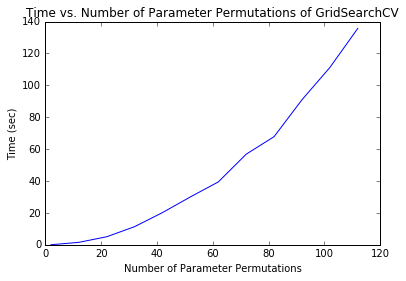

In [34]:
final = pd.DataFrame.from_dict(grid_times)
final = final.sort_index()
plt.plot(final.index.values, final[0])
plt.xlabel('Number of Parameter Permutations')
plt.ylabel('Time (sec)')
plt.title('Time vs. Number of Parameter Permutations of GridSearchCV')

For roughly 100 parameter configurations, it takes about a minute to compute the optimum configuration.  Given that this rate appears to increase at a superlinear rate, the 1000's of configurations we may want to consider cannot be practically computed.  Below I plot the score vs. parameter value graphs for six variables.  From this plot, I can estimate a reasonable range for each parameter to try in `GridSearchCV`.  This method will cut down on the time calculating optimum parameters.  Of course, the downside is that the optimum parameters may still very well fall outside of these ranges.

In [35]:
# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
    grid_search.fit(X_train[features], y_train)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

In [36]:
# parameters and ranges to plot
param_grid = {"n_estimators": np.arange(2, 300, 2),
              "max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(1,150,1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

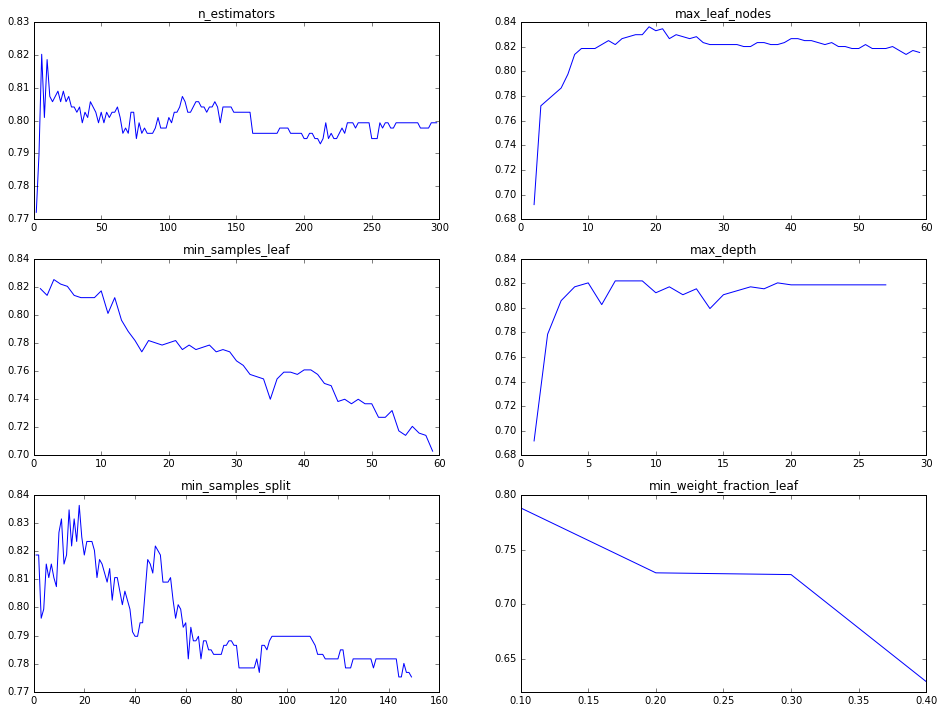

In [37]:
index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1

I can narrow the parameters for `GridSearchCV` using the plots above.  For example, max_leaf_nodes has steadily increasing from 1 to 20 and then it plateaus.  Therefore I will restrict my `GridSearchCV` to the range [18, 22].  Similarly, min_weight_fraction_leaf decreases monotonically, so I won't even look at other values besides the lowest value of 0.1.  This helps restrict the number of permutations I need to run.

In [38]:
from operator import itemgetter

# Utility function to report best scores
def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [39]:
# parameters for GridSearchCV
param_grid2 = {"n_estimators": [10, 18, 22],
              "max_depth": [3, 5],
              "min_samples_split": [15, 20],
              "min_samples_leaf": [5, 10, 20],
              "max_leaf_nodes": [20, 40],
              "min_weight_fraction_leaf": [0.1]}

In [40]:
grid_search = GridSearchCV(clf, param_grid=param_grid2)
grid_search.fit(X_train[features], y_train)

report(grid_search.grid_scores_, 4)

Model with rank: 1
Mean validation score: 0.7849)
Parameters: {'max_leaf_nodes': 20, 'n_estimators': 18, 'min_samples_leaf': 20, 'max_depth': 3, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.1}

Model with rank: 2
Mean validation score: 0.7849)
Parameters: {'max_leaf_nodes': 20, 'n_estimators': 18, 'min_samples_leaf': 20, 'max_depth': 3, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.1}

Model with rank: 3
Mean validation score: 0.7849)
Parameters: {'max_leaf_nodes': 40, 'n_estimators': 18, 'min_samples_leaf': 20, 'max_depth': 3, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.1}

Model with rank: 4
Mean validation score: 0.7849)
Parameters: {'max_leaf_nodes': 40, 'n_estimators': 18, 'min_samples_leaf': 20, 'max_depth': 3, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.1}



I'll tweak certain parameters one-by-one and repeat this process, looking for an increase in mean validation score.  Setting the random_state is useful here to prevent random fluctuations in mean validation score when comparing different parameter combinations.

In [41]:
param_grid3 = {"n_estimators": [5, 40, 42],
              "max_depth": [5, 6],
              "min_samples_split": [5, 10],
              "min_samples_leaf": [3, 5],
              "max_leaf_nodes": [14, 15]}

In [42]:
grid_search = GridSearchCV(clf, param_grid=param_grid3)
grid_search.fit(X_train[features], y_train)

report(grid_search.grid_scores_, 4)

Model with rank: 1
Mean validation score: 0.8266)
Parameters: {'max_leaf_nodes': 15, 'n_estimators': 40, 'min_samples_leaf': 3, 'max_depth': 5, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.8266)
Parameters: {'max_leaf_nodes': 15, 'n_estimators': 40, 'min_samples_leaf': 3, 'max_depth': 6, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.8250)
Parameters: {'max_leaf_nodes': 14, 'n_estimators': 40, 'min_samples_leaf': 3, 'max_depth': 5, 'min_samples_split': 10}

Model with rank: 4
Mean validation score: 0.8218)
Parameters: {'max_leaf_nodes': 14, 'n_estimators': 40, 'min_samples_leaf': 3, 'max_depth': 5, 'min_samples_split': 5}



<a name="Training"></a>
## Training Final Classifier

In [43]:
clf = RandomForestClassifier(min_samples_split = 40, 
                             max_leaf_nodes = 15, 
                             n_estimators = 40, 
                             max_depth = 5,
                             min_samples_leaf = 3)

In [44]:
clf.fit(train_ver2[features], labels);

In [45]:
prediction = clf.predict(test_ver2[features])

output = pd.DataFrame(test_ver2['PassengerId'])
output['Survived'] = prediction
output.to_csv('prediction.csv')

<a name="Conclusion"></a>
## Conclusion
My prediction gave a `0.799` precision rate, which is okay, though I was hoping for a little higher.  I think the parameter tuning method I used above could be tweaked to work better than it did in this case.